/home/alexmak123/yesno/yes
'yes1.png?raw=true'  'yes3.png?raw=true'  'yes5.png?raw=true'
'yes2.png?raw=true'  'yes4.png?raw=true'
(5, 512, 512, 3)
/home/alexmak123/yesno


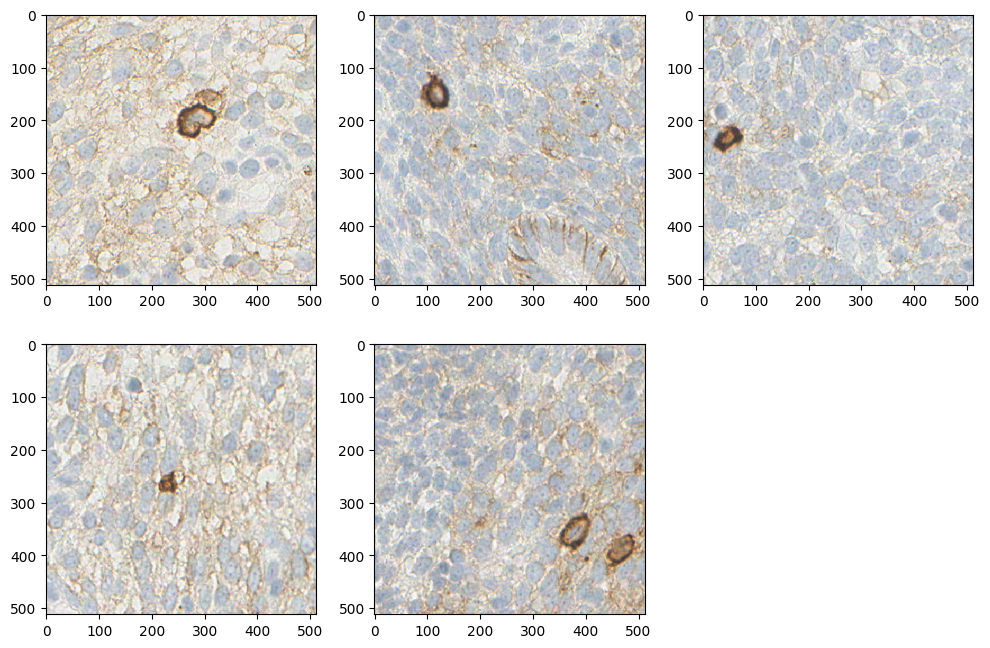

In [1]:
#uploading our plasmatic cells
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image, ImageDraw
from skimage.io import imread, imsave, imshow
import cv2
%matplotlib inline


plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])


#Download our tile
%cd ../yesno/yes
%ls 
directory_in_str = "/home/alexmak123/yesno/yes"

def import_tiles_from_directory_and_convert_them (directory_in_str):
    directory = os.fsencode(directory_in_str)
    i = 1
    converted_images = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith("?raw=true"): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            plt.subplot(3, 3, i)
            imshow(myTile)
            converted_images.append(myTile)
            i += 1
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (directory_in_str)
print (converted_images.shape)
%cd ../

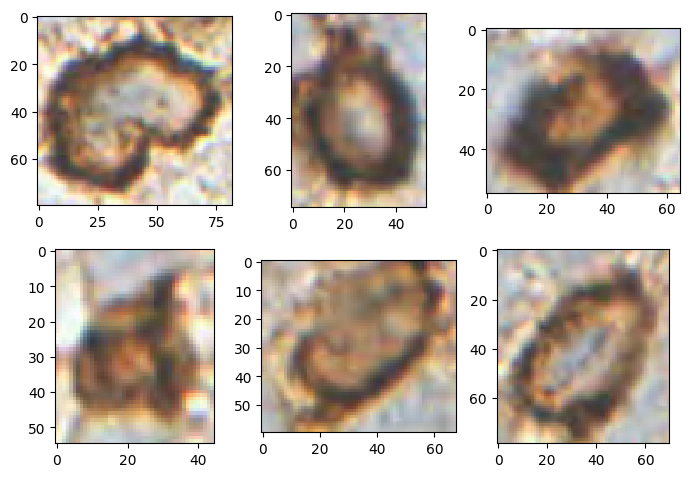

In [2]:
#select the areas, where the plasmatic cells are detected
plt.rcParams["figure.figsize"] = [7, 7]
plt.rcParams["figure.autolayout"] = True

brown_cells = []
#for yes
brown_cells.append(converted_images[0][160:240, 245:327])
brown_cells.append(converted_images[1][110:185, 93:145])
brown_cells.append(converted_images[2][205:260, 15:80])
brown_cells.append(converted_images[3][235:290, 208:253])
brown_cells.append(converted_images[4][365:425, 430:498])
brown_cells.append(converted_images[4][313:392, 345:415])
"""
#for no
brown_cells.append(converted_images[0][180:250, 125:190])
brown_cells.append(converted_images[1][335:390, 270:320])
brown_cells.append(converted_images[2][100:160, 140:200])
brown_cells.append(converted_images[3][200:280, 160:220])
brown_cells.append(converted_images[4][245:480, 270:430])
"""

for i in range(len(brown_cells)):
    plt.subplot(3, 3, i+1)
    imshow(brown_cells[i])

In result we have converted_images[], that represents our tiles and brown_cells[], that represents plasmatic cells in these tiles


Let's apply different filters and see how our images change

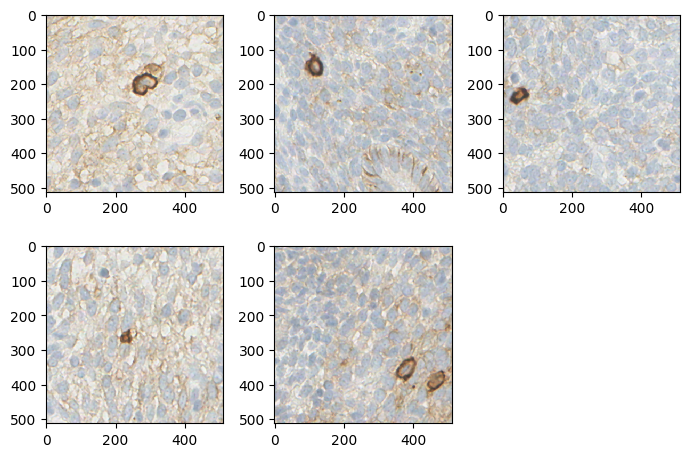

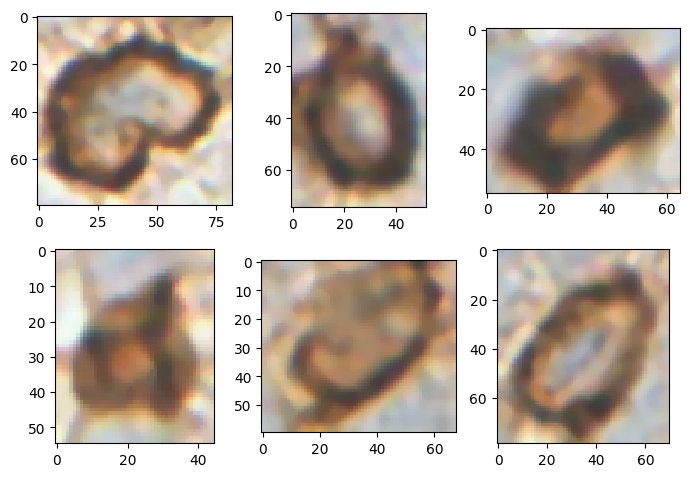

In [3]:
#median filter 5x5

median_filter_size = 5

def median_filter (images_list, size):
    for i in range(len(images_list)):
        median_image  = cv2.medianBlur(images_list[i], size)
        plt.subplot(3, 3, i+1)
        imshow(median_image)
    
    plt.show()

median_filter (converted_images, median_filter_size)
median_filter (brown_cells, median_filter_size)

/home/alexmak123/neurone/venv39/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


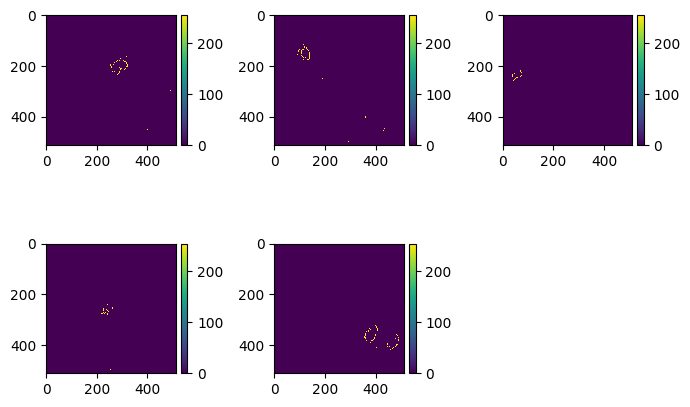

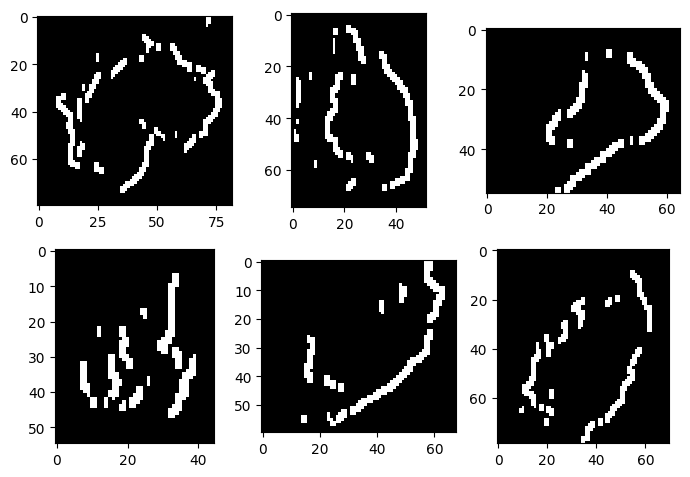

In [4]:
#Sobel filter
#Applies to BlackAndWhite Images

def Sobel_filter (images_list):
    for i in range(len(images_list)):
        
        img_grey = cv2.cvtColor(images_list[i],cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 95, 255, cv2.THRESH_BINARY)
        kernel = np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
    
        plt.subplot(3, 3, i+1)
        imshow(img, vmin=0, vmax=255)
    
    plt.show()

Sobel_filter (converted_images)
Sobel_filter (brown_cells)

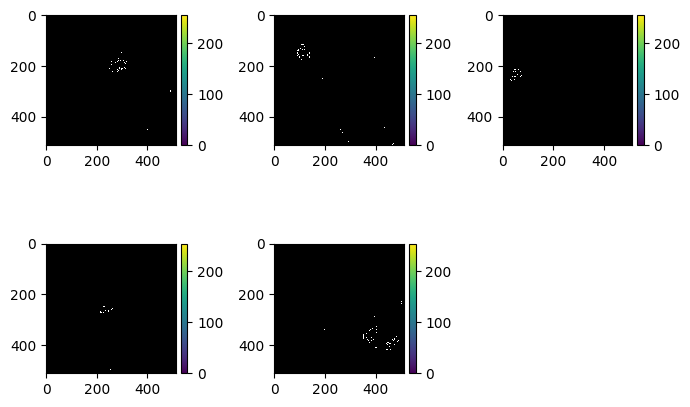

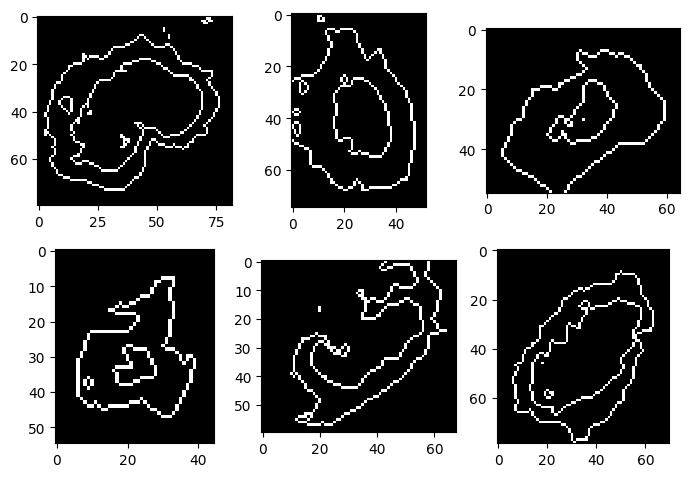

In [5]:
#Laplacian filter 
#Applies to BlackAndWhite Images
#Counts Сontours precisely

def Laplacian_filter (images_list):
    for i in range(len(images_list)):
        
        img_grey = cv2.cvtColor(images_list[i],cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 108, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        img_contours = np.zeros(images_list[i].shape)
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        plt.subplot(3, 3, i+1)
        imshow(img_contours.astype('uint8'), vmin=0, vmax=255)
    
    plt.show()

Laplacian_filter (converted_images)
Laplacian_filter (brown_cells)

amount of contours on picture 1 :  17
amount of contours on picture 2 :  20
amount of contours on picture 3 :  4
amount of contours on picture 4 :  8
amount of contours on picture 5 :  19


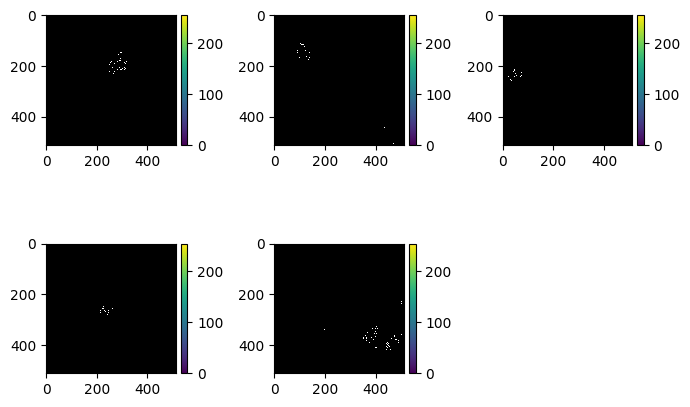

amount of contours on picture 1 :  8
amount of contours on picture 2 :  4
amount of contours on picture 3 :  3
amount of contours on picture 4 :  5
amount of contours on picture 5 :  1
amount of contours on picture 6 :  5


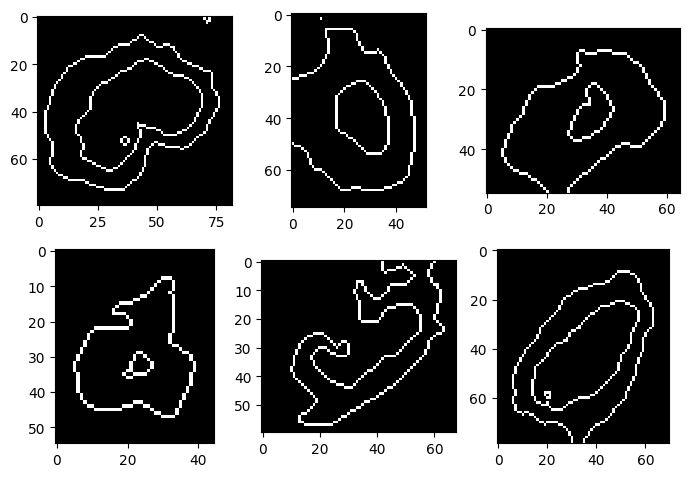

In [6]:
#Now let's apply Laplacian filter to images, that have been pre-processed by the median filter
#Also we will show how many contours the algorithm defines

def median_and_laplacian_filter (images_list, median_filter_size):
    for i in range(len(images_list)):
        
        median_image  = cv2.medianBlur(images_list[i], median_filter_size)
        
        img_grey = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
        #get the image, cropped by the threshold
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 115, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        print ("amount of contours on picture " + str(i+1) + " : ", len(contours))
        img_contours = np.zeros(images_list[i].shape)
        cv2.drawContours(img_contours, contours, -1, (255,255,255), 1)
        
        plt.subplot(3, 3, i+1)
        imshow(img_contours.astype('uint8'), vmin=0, vmax=255)
    
    plt.show()

    
median_filter_size = 5    
    
median_and_laplacian_filter (converted_images, median_filter_size)
median_and_laplacian_filter (brown_cells, median_filter_size)

pic1
(hull_index, parent_hull_index) : 
0 -1
hsv: (11, 80, 117)
1 0
pic2
(hull_index, parent_hull_index) : 
0 -1
hsv: (11, 59, 124)
1 -1
hsv: (10, 73, 111)
2 1
pic3
(hull_index, parent_hull_index) : 
0 -1
hsv: (10, 75, 107)
1 0
pic4
(hull_index, parent_hull_index) : 
0 -1
hsv: (12, 107, 130)
pic5
(hull_index, parent_hull_index) : 
0 -1
hsv: (13, 99, 142)
1 -1
hsv: (13, 94, 131)
2 1


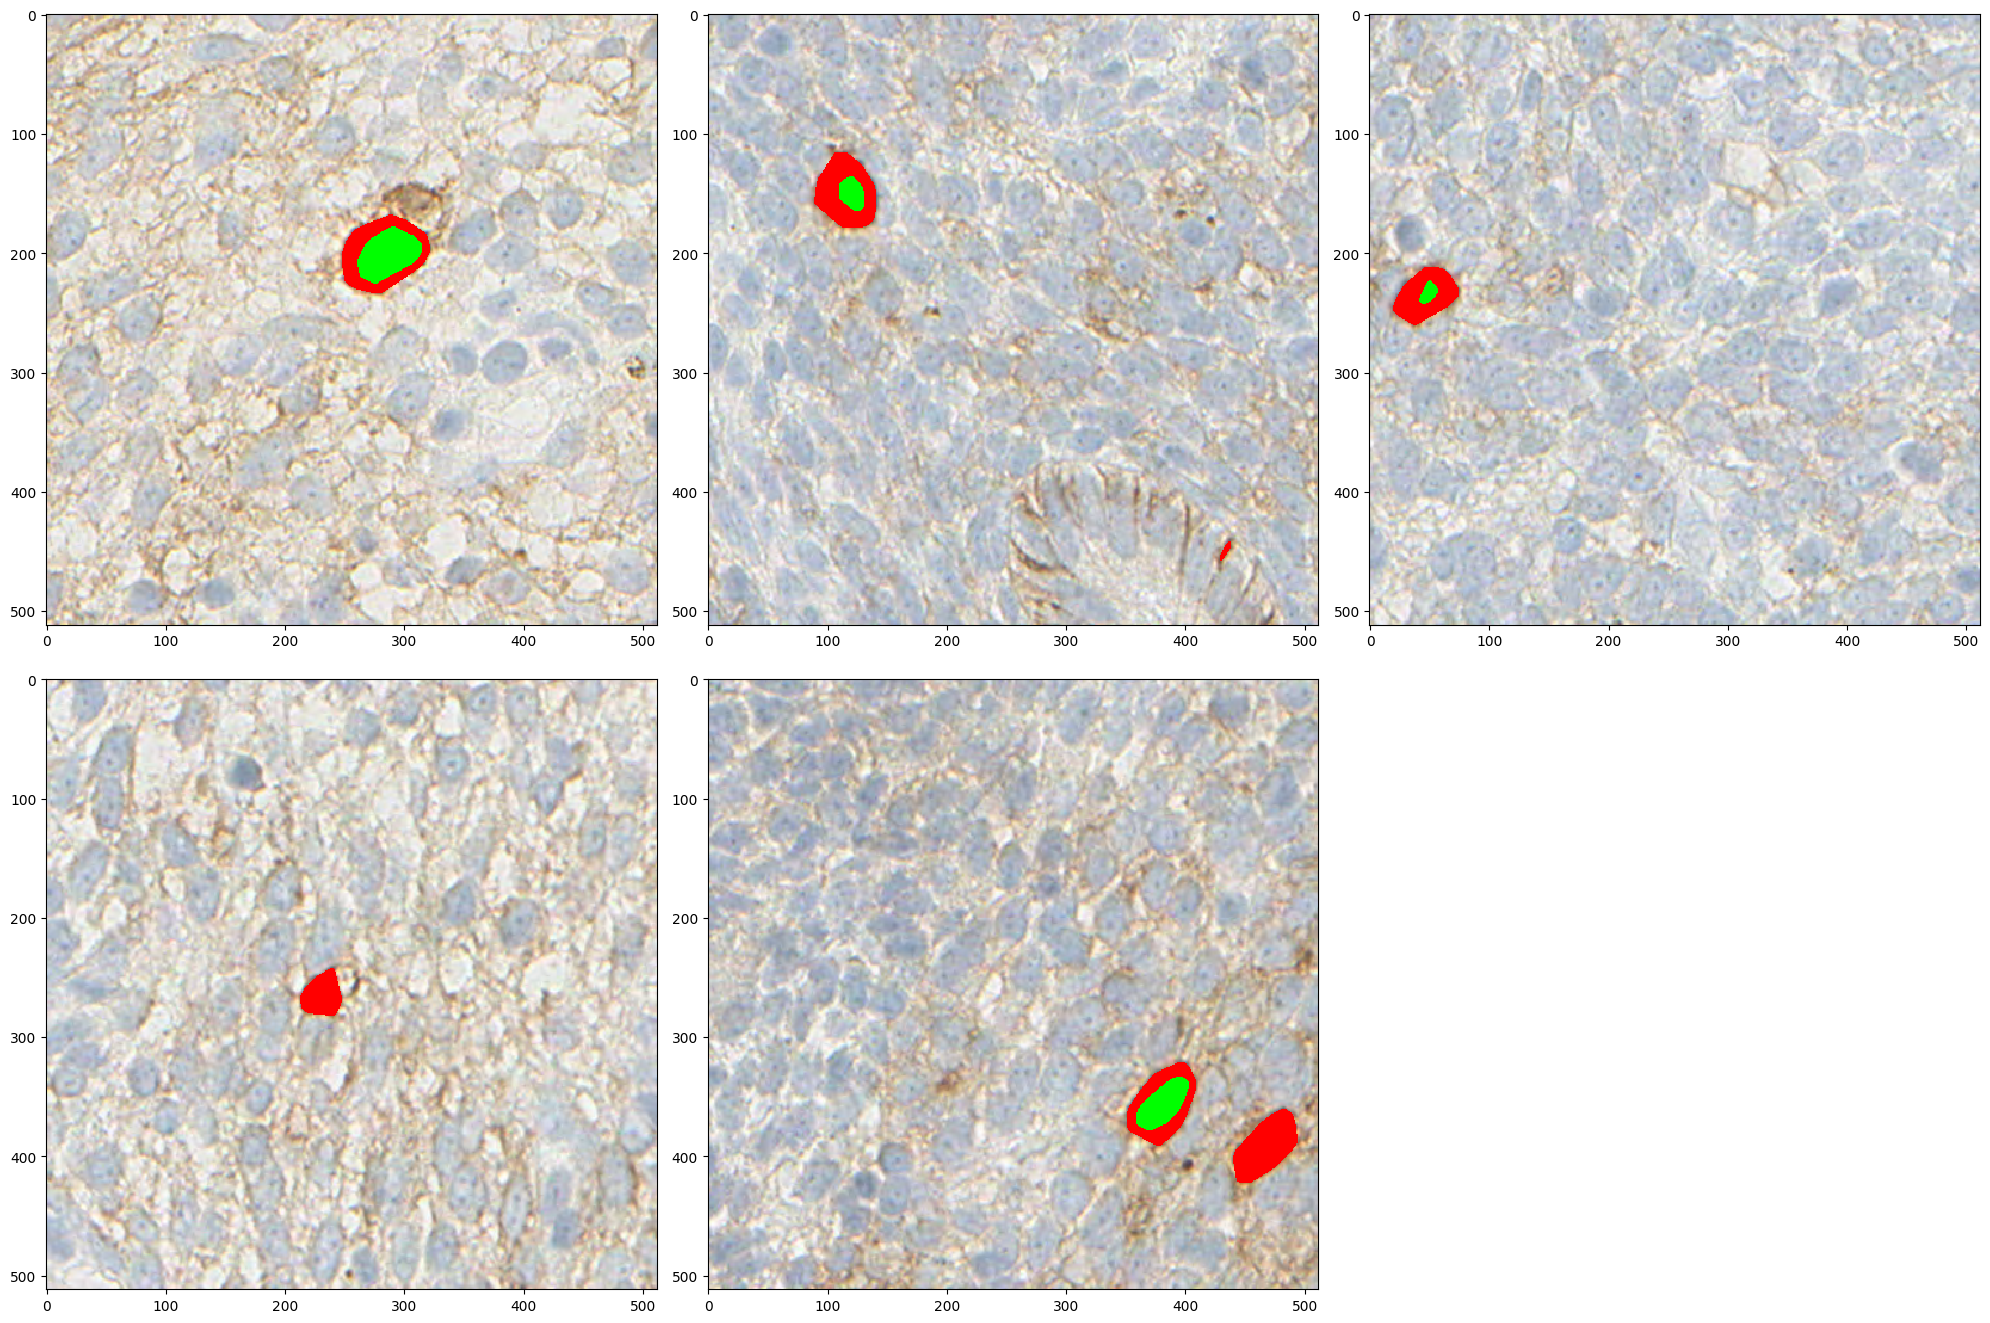

(meanh, means, meanv) :  (11.428571428571429, 83.85714285714286, 123.14285714285714)
(stdh, stds, stdv) :  (1.178030178747903, 15.569462523327713, 11.407122730101216)
pic1
(hull_index, parent_hull_index) : 
0 -1
hsv: (11, 80, 117)
1 0
pic2
(hull_index, parent_hull_index) : 
0 1
1 -1
hsv: (10, 72, 110)
pic3
(hull_index, parent_hull_index) : 
0 1
1 -1
hsv: (10, 76, 108)
pic4
(hull_index, parent_hull_index) : 
0 -1
hsv: (12, 107, 130)
pic5
(hull_index, parent_hull_index) : 
0 -1
hsv: (13, 100, 143)
pic6
(hull_index, parent_hull_index) : 
0 1
1 -1
hsv: (12, 86, 116)


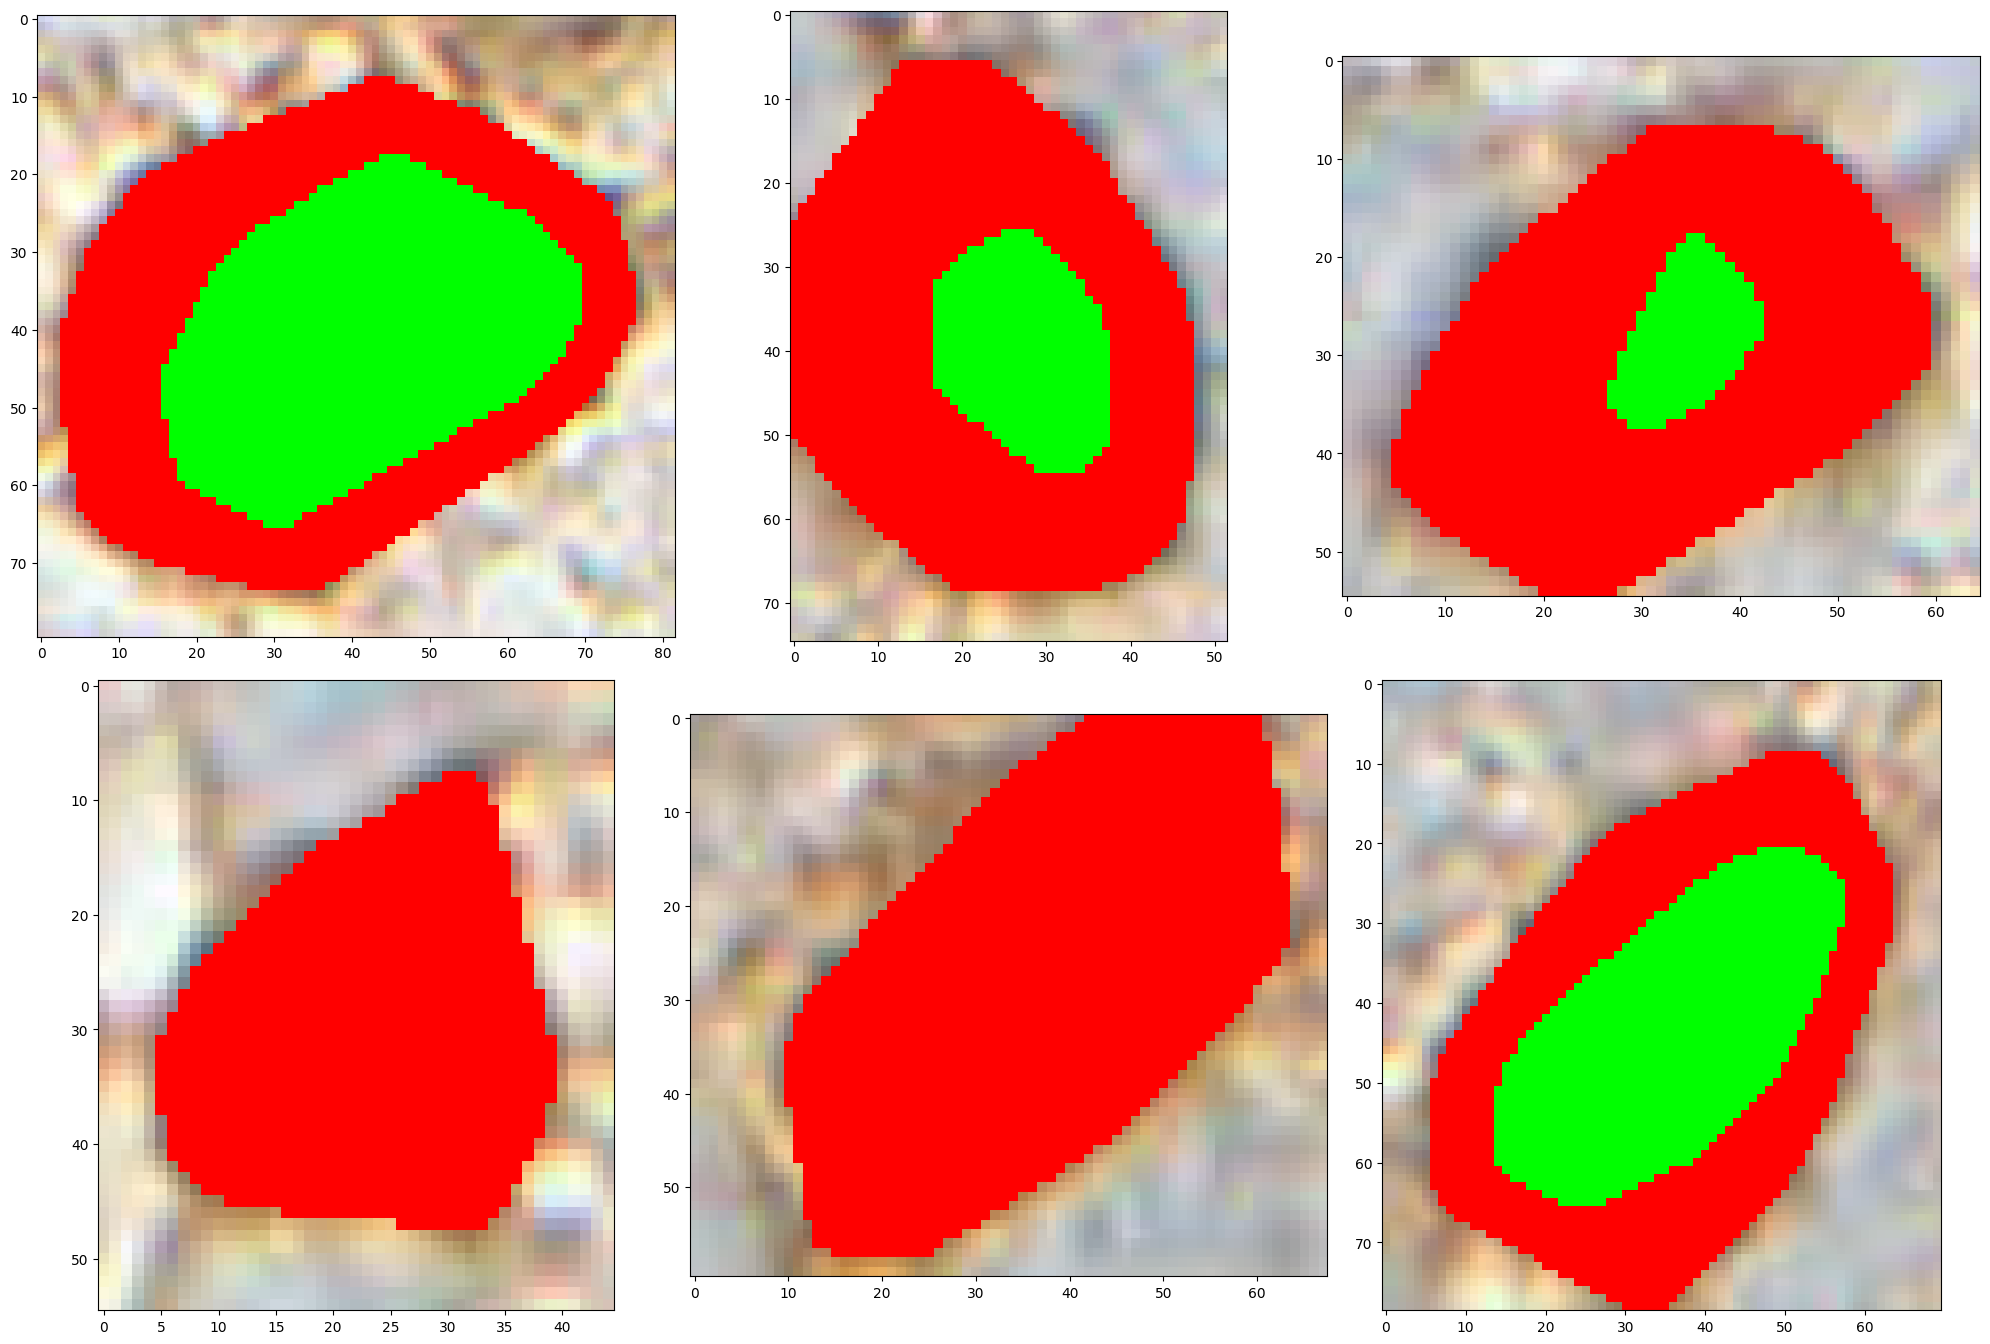

(meanh, means, meanv) :  (11.333333333333334, 86.83333333333333, 120.66666666666667)
(stdh, stds, stdv) :  (1.1055415967851334, 12.680913041084839, 12.215654801205796)


In [7]:
#ConvexHull
#Is used to find clusters of dots on the entire slide
#We add median filter to reduce some noise 
#We use laplacian filter for better precision 


plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True


#def that gets rid of hulls that are noise 
def reduce_noise(hulls, noise_threshold = 30):
    hulls_without_noise = []
    for curr_hull in hulls:
        if (cv2.arcLength(curr_hull, True) >= noise_threshold):
            hulls_without_noise.append(curr_hull)
            
    return hulls_without_noise


#def that removes duplicates of the contours (it is happend because cv2.findContours returns clockwise and non-clockwise oriented contours) 
def get_only_positive_oriented_contours(contours):
    positive_oriented_contours = []
    for curr_contour in contours:
        if (cv2.contourArea(curr_contour, 1) <= 0 and cv2.contourArea(curr_contour, 0) >= 0):
            positive_oriented_contours.append(curr_contour)
    
    return positive_oriented_contours


#def that groups convex hulls in clusters of nested convex hulls (presented as a graph)
def group_convex_hulls(hulls):
    hierarchy = []
    for i in range(len(hulls)):
        #-1 stands for absence of the parent, this means that this convex hull is the outermost of the cell
        parent = -1
        for j in range(len(hulls)):
            if i == j:
                continue
            if cv2.pointPolygonTest(hulls[j], tuple(hulls[i][0][0]), False) >= 0:
                parent = j
                break
        hierarchy.append([i, parent])
    return hierarchy


"""
#def that bypasses using dfs our hierarchy implementation of nested convex hulls and returns index and its depth in the tree
def traverse_hierarchy(hierarchy, root=-1, depth_threshold):
    def dfs(node, depth):
        nonlocal result
        result.append((node, depth))
        for i, (child, parent) in enumerate(hierarchy):
            if parent == node:
                dfs(child, depth + 1)
    
    result = []
    dfs(root, 0)
    return result
"""


#def that finds closest to outer hull, inner hull (if exists)
def find_closest_inner_hull(hierarchy, outer_hull_index):
    inner_hull_index = -2
    for (index, parent) in hierarchy : 
        if (parent == outer_hull_index):
            inner_hull_index = index
            break
            
    return inner_hull_index   


#def that counts mean hsv color of points, bounded by inner(if exists) and outer convex hull 
def coordinates_of_target_pixels_between_two_hulls(curr_picture, hulls, hierarchy, outer_hull_index):
    cv2.fillConvexPoly(curr_picture, hulls[outer_hull_index], (255, 0, 0))
    
    #lets find closest to outer hull, inner hull index (if it's -2, then we don't have an inner_hull)
    inner_hull_index = find_closest_inner_hull(hierarchy, outer_hull_index)
    if (inner_hull_index != -2): 
        cv2.fillConvexPoly(curr_picture, hulls[inner_hull_index], (0, 255, 0))
    
    target_value = (255, 0, 0)
    coordinates_of_target_pixels = []
    #quite seriously increases the running time of our program, it is better not to use it if it is not necessary
    for y in range(curr_picture.shape[0]):
        for x in range(curr_picture.shape[1]):
            if np.all(curr_picture[y, x] == target_value):
                coordinates_of_target_pixels.append((x, y))
                
    # Displaying the image
    imshow(curr_picture.astype('uint8'), vmin=0, vmax=255)  
    return coordinates_of_target_pixels


#def that counts hsv color of target_pixels in the original image
import colorsys
def count_hsv(original_image, coordinates_of_target_pixels):
    pixels = []
    for (y,x) in coordinates_of_target_pixels:
        pixels.append(original_image[x][y])
    
    rgb_mean = np.mean(pixels, axis = 0)
    (rgb_mean[0], rgb_mean[1], rgb_mean[2]) = (rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
    hsv = colorsys.rgb_to_hsv(rgb_mean[0], rgb_mean[1], rgb_mean[2])
    hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
    
    return hsv


#def that is our main convex hull function 
def convex_hull_for_showing(images_list, median_filter_size = 5):
    hsv_brown_cells = []
    for i in range(len(images_list)):
        median_image  = cv2.medianBlur(images_list[i], median_filter_size)
        
        img_grey = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 115, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours,_  = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
        
        #get rid of duplication
        contours = get_only_positive_oriented_contours(contours)
        
        #count hulls
        hulls = []
        img_hulls_and_contours = np.zeros(images_list[i].shape)
        for j in range(len(contours)):
            cv2.drawContours(img_hulls_and_contours, contours, j, (0, 255, 0), 1, 8)
            hulls.append(cv2.convexHull(contours[j], False))
            
        #reduce noise in the hulls
        hulls = reduce_noise(hulls)
        
        #group convex hulls in nested convex hulls
        hierarchy = group_convex_hulls(hulls)
        
        
        #print everything 
        """
        for j in range(len(hulls)):
            cv2.drawContours(img_hulls_and_contours, hulls, j, (255, 0, 0), 1, 8)
        
        print ("amount of convex hulls on picture" + str(i+1) + " : ", len(hulls))
        
        for j in hierarchy: 
            print ("convex hull index : ", j[0], " ; ", "the index of its parent convex hull : ", j[1])
               
        for j in range(len(hulls)):
            print ("length  hull " + str(j) + " : ", cv2.arcLength(hulls[j], True))
        
        plt.subplot(3, 3, i+1)
        imshow(img_hulls_and_contours.astype('uint8'), vmin=0, vmax=255)
        """
        
        curr_img = images_list[i].copy()
        print ("pic" + str(i+1))
        plt.subplot(3, 3, i+1)
        print ("(hull_index, parent_hull_index) : ")
        for (index, parent) in (hierarchy):
            print (index, parent)
            if (parent == -1):
                arr = coordinates_of_target_pixels_between_two_hulls (curr_img, hulls, hierarchy, index)
                hsv_brown_cells.append(count_hsv(images_list[i], arr))
                print ("hsv:", count_hsv(images_list[i], arr))
    
    plt.show()
    
    (meanh, means, meanv) = np.mean(hsv_brown_cells, axis=0)
    print ("(meanh, means, meanv) : ", (meanh, means, meanv))
    (stdh, stds, stdv) = np.std(hsv_brown_cells, axis=0)
    print ("(stdh, stds, stdv) : ", (stdh, stds, stdv)) 
        
        
median_filter_size = 5        

convex_hull_for_showing(converted_images, median_filter_size)
convex_hull_for_showing(brown_cells, median_filter_size)

## By analyzing hsv results of confirmed plasmatic cells we can say that plasmatic cell have:

We can say that:  10 - std <= hue <= 13 + std

mean(h) = 11.3

std(h) = 1.1

We can say that: 59 - std <= saturation <= 107 + std 

mean(s) = 86.8

std(s) = 12.7

We can say that: 108 - std <= value <= 143 + std 

mean(v) = 120.7

std(v) = 12.2